In [7]:
import numpy as np
import matplotlib.pyplot as plt
from onix.experiments.helpers
import scipy

%matplotlib inline

In [144]:
t_on = 10e-6
t_off = 2e-6
N_mu = 20
t_total = (t_on + t_off) * N_mu
N = 200

sample_rate = 25e6
N_step = int(t_total * sample_rate)
ts = np.arange(0, N_step * N) / sample_rate

In [145]:
def voltage_sine(f, phase=0):
    return np.sin(2 * np.pi * f * ts + phase) * np.sqrt(2)

In [146]:
def data_points(voltages):
    points = []
    for kk in range(N_mu):
        start = int(kk * (t_on + t_off) * sample_rate)
        end = int((kk * (t_on + t_off) + t_on) * sample_rate)
        points.append(np.average(voltages[start:end]))
    return np.array(points)

In [147]:
phases = np.linspace(0, 2 * np.pi, 8)
def data_points(f, phase):
    N_step = int(t_total * sample_rate)
    V = voltage_sine(f, phase).reshape(N, N_step)
    dps = []
    for kk in range(N_mu):
        start = int(kk * (t_on + t_off) * sample_rate)
        end = int((kk * (t_on + t_off) + t_on) * sample_rate)
        dp = np.average(V[:, start:end])
        dps.append(dp)
    return dps

In [148]:
stds = []
fs = np.logspace(0, 8, 100)
for f in fs:
    std_f = []
    for phase in phases:
        std_f.append(np.std(data_points(f, phase)))
    stds.append(np.average(std_f))
stds = np.array(stds)

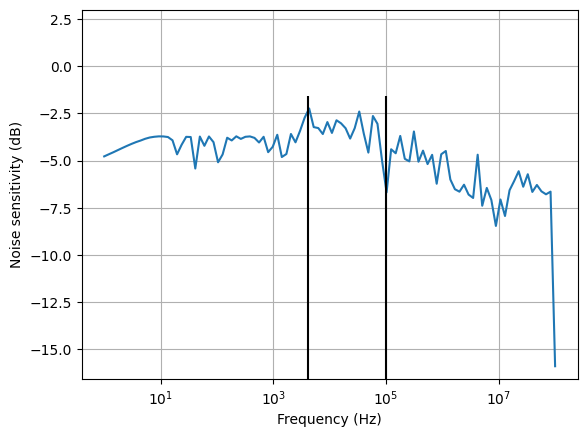

In [150]:
fig, ax = plt.subplots()
ax.plot(fs, np.log10(stds ** 2) * 10 / np.sqrt(N))
ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_ylim(-70, 3)
ylim_low, ylim_high = ax.get_ylim()
ax.vlines([1 / t_on, 1 / t_total], ylim_low, ylim_high, color="k")
ax.set_ylim(np.max([ylim_low, -70]), 3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Noise sensitivity (dB)")
ax.grid()
plt.show()